In [1]:
# !apt update
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
# !tar -xvf spark-3.3.0-bin-hadoop3.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# %cd '/content/gdrive/My Drive/LDS9/Practice/Chapter9/'

/content/gdrive/My Drive/LDS9/Practice/Chapter9


# Demo KMeans Clustering

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('kmeans_demo').getOrCreate()

In [5]:
# Loads data.
data = spark.read.csv("5000_points.txt", header=False,
                      inferSchema=True, sep="\t")

In [6]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [7]:
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import *

In [8]:
data = data.select(col("_c0").alias("x"), col("_c1").alias("y"))

In [9]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



## Format from data

In [10]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [11]:
data.columns

['x', 'y']

In [12]:
vec_assembler = VectorAssembler(inputCols= data.columns,
                               outputCol='features')

In [13]:
final_data = vec_assembler.transform(data)

## Scale the data

In [19]:
from pyspark.ml.feature import StandardScaler


In [20]:
scaler  = StandardScaler(inputCol='features',
                        outputCol='scaledFeatures',
                        withStd=True, withMean=False)

In [21]:
scalerModel = scaler.fit(final_data)

In [22]:
final_data = scalerModel.transform(final_data)

In [24]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



## Train the Model and Evaluate

In [25]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [26]:
# Trains a k-means model.
# Trains a k-means model.
k_list = []
silhouette_list = []
sil_str = ""

for k in range(2,11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    k_list.append(k)

    # silhoutte
    predictions = model.transform(final_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [27]:
print(sil_str)

With k =2- Silhouette = 0.4905230801652404
With k =3- Silhouette = 0.5792896233278176
With k =4- Silhouette = 0.614662491276157
With k =5- Silhouette = 0.5631173426262572
With k =6- Silhouette = 0.5969042561069686
With k =7- Silhouette = 0.6801981675814812
With k =8- Silhouette = 0.7002697206196439
With k =9- Silhouette = 0.6389102664275077
With k =10- Silhouette = 0.698519085337131



In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

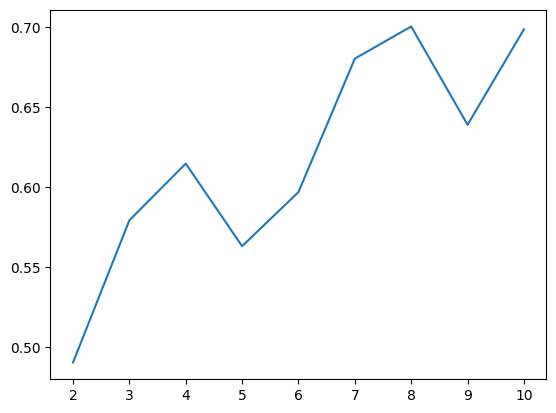

In [29]:
plt.plot(k_list, silhouette_list)
plt.show()

In [30]:
## Select k=4 (check groups after clustering)

In [31]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures', k=4)
model = kmeans.fit(final_data)

In [32]:
# silhoutte
predictions = model.transform(final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhoutte = " + str(silhouette))

Silhoutte = 0.614662491276157


In [33]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.4269584  1.16075811]
[3.03342052 2.90328734]
[3.08780652 1.24665641]
[1.14935944 2.91456287]


In [36]:
predictions =  model.transform(final_data)

In [35]:
predictions.show(5)

+------+------+-------------------+--------------------+----------+
|     x|     y|           features|      scaledFeatures|prediction|
+------+------+-------------------+--------------------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|         1|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|         1|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|         1|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|         1|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|         1|
+------+------+-------------------+--------------------+----------+
only showing top 5 rows



In [37]:
predictions.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1302|
|         3| 1328|
|         2| 1008|
|         0| 1362|
+----------+-----+



In [39]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()


In [40]:
temp = temp.select(col("_1").alias("x_scale"), col("_2").alias("y_scale"))
temp.show(5)

+------------------+------------------+
|           x_scale|           y_scale|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
|2.5304142423414357|2.3382123709986073|
|2.6003217421823916|2.5782047187507375|
+------------------+------------------+
only showing top 5 rows



In [41]:
# Combine temp -> predictions
predictions=predictions.withColumn('row_index', monotonically_increasing_id())
temp=temp.withColumn('row_index', monotonically_increasing_id())
predictions = predictions.join(temp, on=["row_index"]).sort("row_index")
df = predictions.toPandas()
centers_df = pd.DataFrame(centers)
centers_df = centers_df.rename(columns={0: "x_center", 1: "y_center"})
centers_df.head()


,x_center,y_center
0,1.426958,1.160758
1,3.033421,2.903287
2,3.087807,1.246656
3,1.149359,2.914563


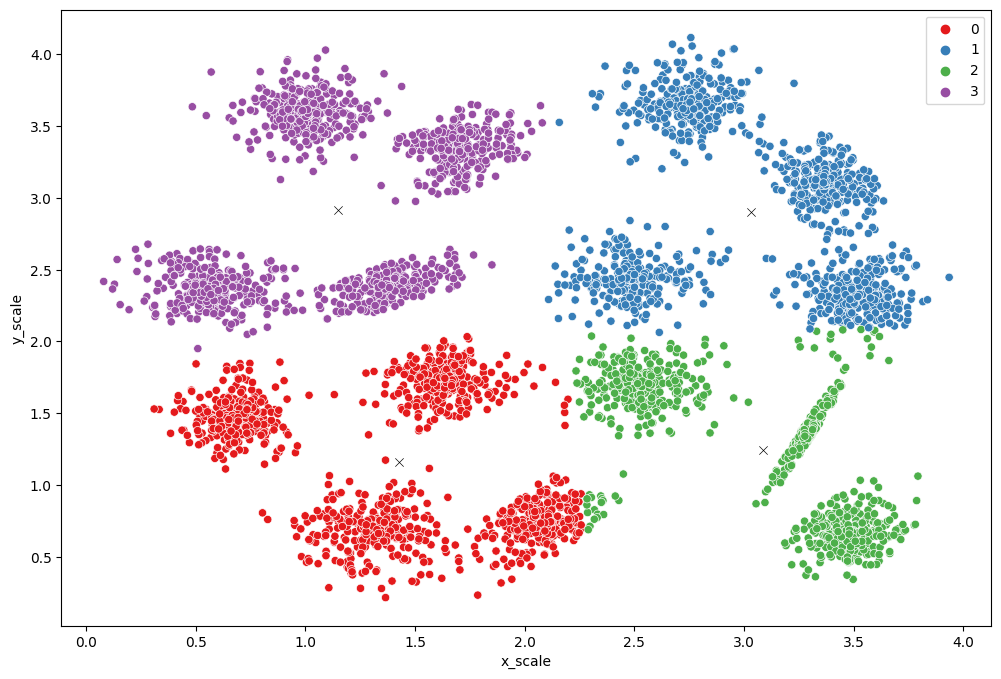

In [42]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="x_scale", y="y_scale", data = df,
                hue="prediction",
                # size = "prediction",
                palette="Set1")
sns.scatterplot(data = centers_df, x='x_center', y='y_center', color="black", marker="x")
plt.show()